In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import  nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("GPTsentimentanalysis.csv")
df.shape

(219294, 3)

In [3]:
df.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [4]:
df.drop("Unnamed: 0", axis = 1, inplace = True)
df.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [5]:
df.isna().sum()

tweets    0
labels    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(1671)

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217623 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  217623 non-null  object
 1   labels  217623 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB


In [9]:
df["labels"].value_counts()

labels
bad        106695
good        55754
neutral     55174
Name: count, dtype: int64

In [10]:
df["labels"] = df["labels"].map({"bad":0 , "neutral":1 ,"good":2})
df["labels"].value_counts()

labels
0    106695
2     55754
1     55174
Name: count, dtype: int64

In [11]:
df = df.reset_index(drop=True)
df.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,1
1,"Try talking with ChatGPT, our new AI system wh...",2
2,ChatGPT: Optimizing Language Models for Dialog...,1
3,"THRILLED to share that ChatGPT, our new model ...",2
4,"As of 2 minutes ago, @OpenAI released their ne...",0


In [12]:
X = df["tweets"]
y = df["labels"]
print(f"the shape of Features : {X.shape}")
print(f"the shape of Labels : {y.shape}")

the shape of Features : (217623,)
the shape of Labels : (217623,)


In [13]:
tweets_copy = X.copy()
tweets_copy.head()

0    ChatGPT: Optimizing Language Models for Dialog...
1    Try talking with ChatGPT, our new AI system wh...
2    ChatGPT: Optimizing Language Models for Dialog...
3    THRILLED to share that ChatGPT, our new model ...
4    As of 2 minutes ago, @OpenAI released their ne...
Name: tweets, dtype: object

In [14]:
tweets_copy[0]

'ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI'

In [15]:
Lemmatizer = WordNetLemmatizer()

corpus = []

for i in range(0,len(tweets_copy)):
    review = re.sub("[^a-zA-Z]", " " , tweets_copy[i])
    review = re.sub(r'#\w+\s*', '', review)
    review = re.sub(r'http\S+', '', review)
    review = re.sub(r'\s+', ' ', review).strip()

    review = review.lower()
    review = word_tokenize(review)
    review = [Lemmatizer.lemmatize(word) for word in review if word not in stopwords.words("english")]
    review = " ".join(review)
    corpus.append(review)

print(corpus[0])  

chatgpt optimizing language model dialogue co k rkrygyyn openai


In [16]:
# Vocabulary Size
voc_size = 20000

tokenizer = Tokenizer(num_words = voc_size , oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

In [17]:
sequences[0]

[2, 1281, 51, 41, 536, 3, 101, 1, 6]

In [18]:
corpus[0]

'chatgpt optimizing language model dialogue co k rkrygyyn openai'

In [19]:
max_length = 0
for i in sequences:
    if len(i)>max_length:
        max_length = len(i)

print(max_length)

56


In [20]:
embedded_docs = pad_sequences(sequences,padding = "post" , maxlen = max_length )
print(embedded_docs[0])

[   2 1281   51   41  536    3  101    1    6    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [21]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [22]:
print(f"the final features shape : {X_final.shape}")
print(f"the final label shape : {y_final.shape}")

the final features shape : (217623, 56)
the final label shape : (217623,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final, test_size=0.15, shuffle=True, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(184979, 56) (32644, 56) (184979,) (32644,)


In [24]:
X_train,X_val , y_train, y_val =  train_test_split(X_train, y_train ,test_size=0.15, random_state=0 , shuffle=True)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape )

(157232, 56) (27747, 56) (157232,) (27747,)


In [37]:
embedded_vector_feature = 50

model = Sequential([
    Embedding(input_dim= voc_size , output_dim=embedded_vector_feature, input_shape = (max_length,)),
    LSTM(128),
    Dropout(0.2),
    Dense(3, activation="softmax")
])


model.compile(optimizer = "adam",
              loss= "sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [38]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 56, 50)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092,035 (4.17 MB)

 Trainable params: 1,092,035 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
early_stopping = EarlyStopping(patience=3 , restore_best_weights=True)
checkpoint = ModelCheckpoint("Sentiment_analysis_LSTM.keras", save_best_only=True)

In [40]:
history = model.fit(X_train,y_train, epochs=20, batch_size = 128, 
          validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])


Epoch 1/20
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 96s 76ms/step - accuracy: 0.6913 - loss: 0.7000 - val_accuracy: 0.8739 - val_loss: 0.3619
Epoch 2/20
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 93s 76ms/step - accuracy: 0.9038 - loss: 0.2913 - val_accuracy: 0.9076 - val_loss: 0.2748
Epoch 3/20
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 95s 77ms/step - accuracy: 0.9313 - loss: 0.2262 - val_accuracy: 0.9048 - val_loss: 0.2755
Epoch 4/20
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 93s 75ms/step - accuracy: 0.9421 - loss: 0.1984 - val_accuracy: 0.9096 - val_loss: 0.2846
Epoch 5/20
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 93s 76ms/step - accuracy: 0.9500 - loss: 0.1764 - val_accuracy: 0.9109 - val_loss: 0.2686
Epoch 6/20
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 93s 76ms/step - accuracy: 0.9550 - loss: 0.1601 - val_accuracy: 0.9095 - val_loss: 0.2935
Epoch 7/20
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 95s 77ms/step - accuracy: 0.9608 - loss: 0.1421 - val_accuracy: 0.9058 - val_loss: 0.3137
Epoch 8/20
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 95s 77ms/step - accuracy: 0.9646 -

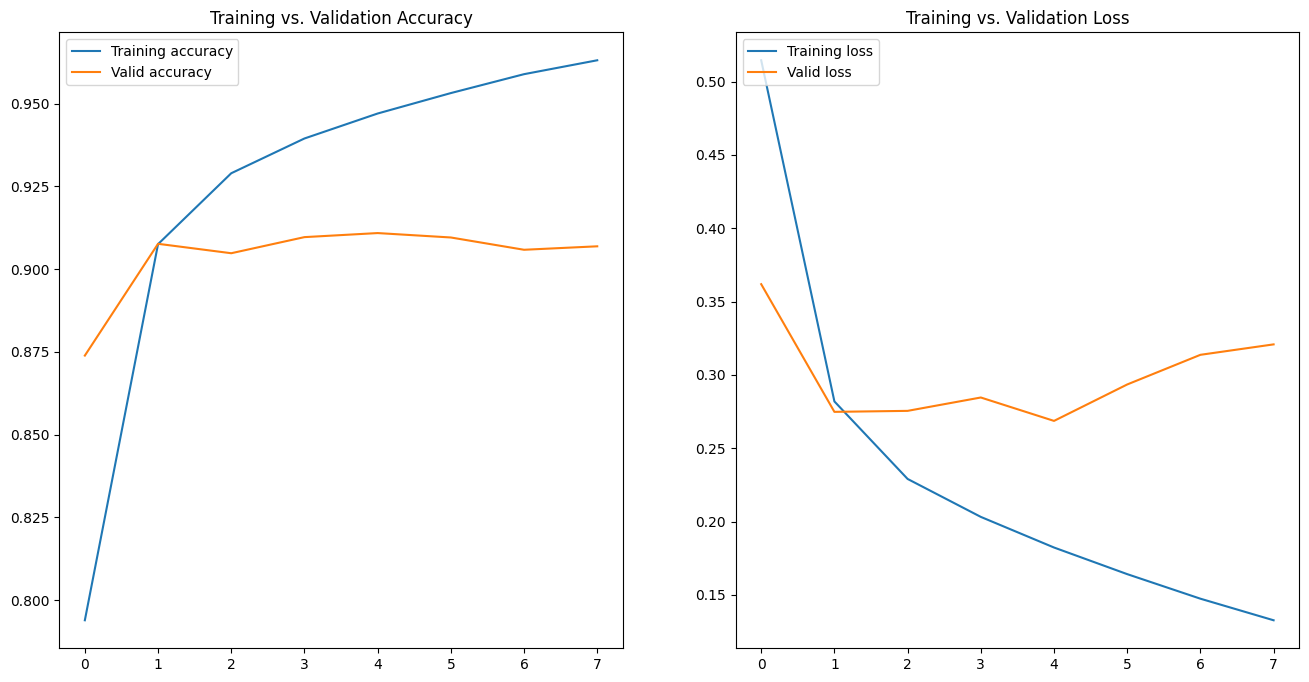

In [41]:
loss = history.history["loss"]
accuracy = history.history['accuracy']
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs_range = range(len(accuracy))

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range , accuracy , label = "Training accuracy")
plt.plot(epochs_range, val_accuracy , label = "Valid accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend(loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs_range , loss , label="Training loss")
plt.plot(epochs_range, val_loss, label="Valid loss")
plt.title("Training vs. Validation Loss")
plt.legend(loc = "upper left")

plt.show()

In [42]:
loss , accuracy = model.evaluate(X_test,y_test, )
print(f"Test loss : {loss:.4f}")
print(f"Test accuracy : {accuracy*100:.2f}%")

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9149 - loss: 0.2606
Test loss : 0.2648
Test accuracy : 91.32%


In [43]:
y_prop = model.predict(X_test)
y_prop[:3]

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step


array([[0.9958281 , 0.00285547, 0.00131642],
       [0.9908105 , 0.00648562, 0.00270391],
       [0.94918495, 0.04381505, 0.00699998]], dtype=float32)

In [47]:
pred_classes = np.argmax(y_prop, axis=1)
print(pred_classes)

[0 0 0 ... 0 0 2]


In [49]:
cm = confusion_matrix(y_test, pred_classes)
cm

array([[15119,   879,   132],
       [  533,  7018,   664],
       [   76,   549,  7674]])

In [51]:
print("the classification report for LSTM : ")
print(classification_report(y_test, pred_classes))

the classification report for LSTM : 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     16130
           1       0.83      0.85      0.84      8215
           2       0.91      0.92      0.92      8299

    accuracy                           0.91     32644
   macro avg       0.90      0.91      0.90     32644
weighted avg       0.91      0.91      0.91     32644



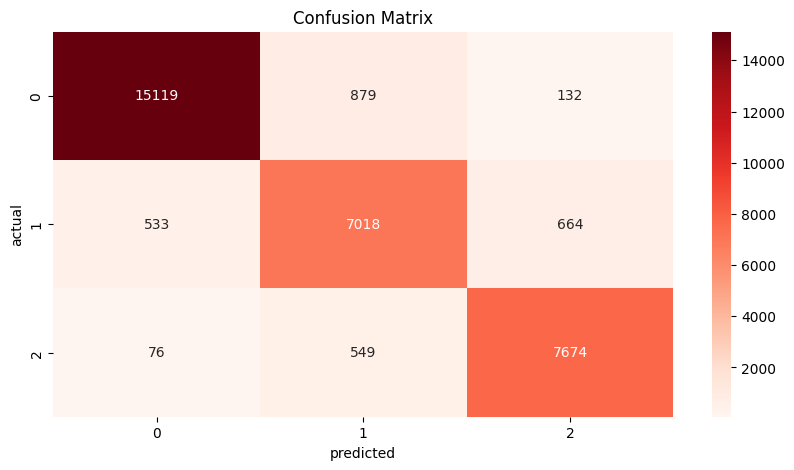

In [52]:
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap="Reds" , fmt="d")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()